# Imports

In [11]:
import time
import pynlo
import numpy as np
import matplotlib.pyplot as plt
from load_data import load_data
from generate_data import generate_data
from train_models import train_models, train_best

# Generate data
`generate_data()` runs `PyNLO` for each given parameter and saves the temporal/spectral inputs/output evolution in `DATA_DIR`

In [3]:
DATA_DIR = f"./testing_data/nlse_time-{int(time.time())}/"
LOG_DIR = "logs/"

generate_data(DATA_DIR)

100%|██████████| 32/32 [07:46<00:00, 14.58s/it]


Done generating data. The following files have been created:
x_pulse_AW.npy: (1024, 10, 1024)
x_pulse_AT.npy: (1024, 10, 1024)
y_AW.npy: (1024, 110, 1024)
y_AT.npy: (1024, 110, 1024)


# Train models
`keras.tuner.RandomSearch()` iterates randomly over hyperparameters and runs a model for each. `train_models()` runs a given amount of these models and returns the best one. `train_best()` immediately follows, training and returning the best performing model. 

In [2]:
# for testing
DATA_DIR = "./testing_data/nlse_time-1657844810/"
LOG_DIR = "logs/"

x_train, y_train, x_val, y_val, x_test, y_test = load_data(
    DATA_DIR=DATA_DIR, validation_split=0.2, test_split=0.2
)

Input data shape: (1024, 10, 1024)
Output data shape: (1024, 110, 1024)
Training data shape: (616, 10, 1024)
Validation data shape: (204, 10, 1024)
Testing data shape: (204, 10, 1024)


In [3]:
tuner, hps = train_models(
    DATA_DIR=DATA_DIR,
    LOG_DIR=LOG_DIR,
    x_train=x_train,
    y_train=y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
)

Trial 1 Complete [00h 00m 44s]
val_mse: 2.4165290597011335e-05

Best val_mse So Far: 2.4165290597011335e-05
Total elapsed time: 00h 00m 44s
INFO:tensorflow:Oracle triggered exit


Epoch 1/10
20/20 [==============================] - 6s 211ms/step - loss: 0.2497 - mse: 0.2497 - mae: 0.4997 - val_loss: 0.2496 - val_mse: 0.2496 - val_mae: 0.4995
Epoch 2/10
20/20 [==============================] - 4s 191ms/step - loss: 0.2494 - mse: 0.2494 - mae: 0.4993 - val_loss: 0.2491 - val_mse: 0.2491 - val_mae: 0.4991
Epoch 3/10
20/20 [==============================] - 4s 199ms/step - loss: 0.2489 - mse: 0.2489 - mae: 0.4989 - val_loss: 0.2485 - val_mse: 0.2485 - val_mae: 0.4985
Epoch 4/10
20/20 [==============================] - 4s 202ms/step - loss: 0.2478 - mse: 0.2478 - mae: 0.4978 - val_loss: 0.2462 - val_mse: 0.2462 - val_mae: 0.4961
Epoch 5/10
20/20 [==============================] - 4s 211ms/step - loss: 0.2313 - mse: 0.2313 - mae: 0.4802 - val_loss: 0.1799 - val_mse: 0.1799 - val_mae: 0.4205
Epoch 6/10
20/20 [==============================] - 4s 196ms/step - loss: 0.0460 - mse: 0.0460 - mae: 0.1458 - val_loss: 2.4172e-05 - val_mse: 2.4172e-05 - val_mae: 2.3722e-04
Epoc

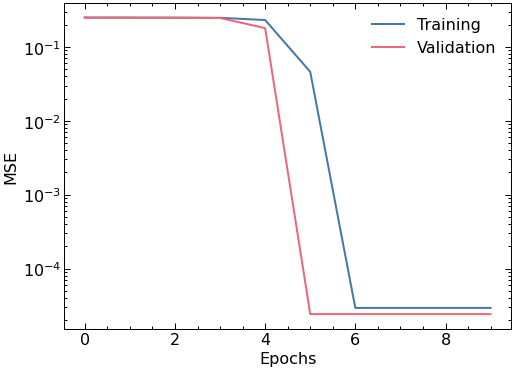

In [4]:
model = train_best(
    DATA_DIR=DATA_DIR,
    LOG_DIR=LOG_DIR,
    x_train=x_train,
    y_train=y_train,
    validation_data=(x_val, y_val),
    tuner=tuner,
    hps=hps,
    epochs=10,
)

# Make predictions and plot results
Makes a prediction with the best performing model on a data set that is outside the initial training data.

In [27]:
pred = np.absolute(model.predict(x_test))
pred = pred / np.max(pred)

7/7 [==============================] - 0s 36ms/step


# Plot results

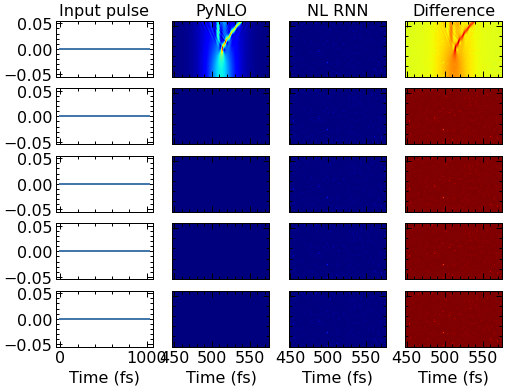

In [51]:
plt.style.use(["science", "notebook", "bright"])

_, axes = plt.subplots(5, 4)  # , sharex=True)

# extent = [512-16, 512+16, 0, 100]

for i in range(5):
    x = pred[i, :, :]

    y = np.absolute(y_test[i, :, :])

    axes[i, 0].plot(np.absolute(np.transpose(x_test[i, 0, :])))
    axes[i, 0].set_xlabel("Time (fs)")

    axes[i, 1].imshow(y, aspect="auto", cmap="jet", origin="lower")
    axes[i, 1].set_xlim(512 - 64, 512 + 64)
    axes[i, 1].set_xlabel("Time (fs)")

    axes[i, 2].imshow(x, aspect="auto", cmap="jet", origin="lower")
    axes[i, 2].set_xlim(512 - 64, 512 + 64)
    axes[i, 2].set_xlabel("Time (fs)")

    axes[i, 3].imshow(y - x, aspect="auto", cmap="jet", origin="lower")
    axes[i, 3].set_xlim(512 - 64, 512 + 64)
    axes[i, 3].set_xlabel("Time (fs)")

    if i == 0:
        axes[i, 0].set_title("Input pulse")
        axes[i, 1].set_title("PyNLO")
        axes[i, 2].set_title("NL RNN")
        axes[i, 3].set_title("Difference")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for axis in axes.flat:
    axis.label_outer()

plt.show()

# Save publication quality plots

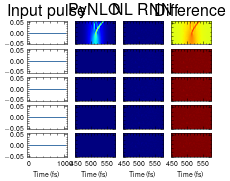

In [54]:
plt.style.use(["science", "nature", "bright"])

_, axes = plt.subplots(5, 4)  # , sharex=True)

for i in range(5):
    x = pred[i, :, :]

    y = np.absolute(y_test[i, :, :])

    axes[i, 0].plot(np.absolute(np.transpose(x_test[i, 0, :])))
    axes[i, 0].set_xlabel("Time (fs)")

    axes[i, 1].imshow(y, aspect="auto", cmap="jet", origin="lower")
    axes[i, 1].set_xlim(512 - 64, 512 + 64)
    axes[i, 1].set_xlabel("Time (fs)")

    axes[i, 2].imshow(x, aspect="auto", cmap="jet", origin="lower")
    axes[i, 2].set_xlim(512 - 64, 512 + 64)
    axes[i, 2].set_xlabel("Time (fs)")

    axes[i, 3].imshow(y - x, aspect="auto", cmap="jet", origin="lower")
    axes[i, 3].set_xlim(512 - 64, 512 + 64)
    axes[i, 3].set_xlabel("Time (fs)")

    if i == 0:
        axes[i, 0].set_title("Input pulse")
        axes[i, 1].set_title("PyNLO")
        axes[i, 2].set_title("NL RNN")
        axes[i, 3].set_title("Difference")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for axis in axes.flat:
    axis.label_outer()

plt.savefig(f"figures/results-{int(time.time())}.png", dpi=2400)

In [ ]:
plt.plot()